# Objectifs : 
1. Tracer l'évolution sur une période donnée (NB_JOURS) de la capitalisation des X (X_TOP_CRYPTO) plus grosses cryptos.
2. Superposer à ce graphique, l'indice de prix d'une crypto de référence (REF_CRYPTO) 

# Guide nomenclature : 
- snake_case pour 
    - les variables 
    - les listes (au pluriel)
    - les dictionnaires (clé_valeur)
    - les fonctions (action)
- CamelCase pour 
    - les classes 
- MAJUSCULES pour 
    - les constantes 
- _underscore pour 
    - les attributs privés de classe 

In [24]:
# Libraries
from pycoingecko import CoinGeckoAPI
import pandas as pd 
import matplotlib.pyplot as plt
import datetime

In [25]:
# Initialiser le client CoinGecko
cg = CoinGeckoAPI()

# Initialiser les constantes 
JOURS = 30
X_TOP_CRYPTO = 10
REF_CRYPTO = 'bitcoin'

In [26]:
# Fonction récupérant la liste des X premières cryptos par capitalisation
def get_top_ids(top_coin=20):
    coins = cg.get_coins_markets(vs_currency='usd', order='market_cap_desc', per_page=top_coin, page=1)
    return [coin['id'] for coin in coins]

# Fonction récupérant l'historique de la capitalisation d'unecrypto
def get_historical_market_caps(coin_id, days="30", vs_currency="usd"):
    data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency=vs_currency, days=days)
    return data['market_caps']

In [27]:
# Récupérer le cours d'une crypto sur une période donnée
# Récupérer le timestamp d'aujourd'hui
to_timestamp = pd.Timestamp.today().timestamp()

# Récupérer le timestamp d'il y a 30 jours
from_timestamp = pd.Timestamp.today() - pd.DateOffset(days=JOURS)
from_timestamp = from_timestamp.timestamp()  # Conversion en timestamp

# Récupérer le prix de la référence sur les 30 derniers jours
ref_crypto_prices = cg.get_coin_market_chart_range_by_id(
    id=REF_CRYPTO, 
    vs_currency='usd', 
    from_timestamp=from_timestamp,
    to_timestamp=to_timestamp)

df_ref_crypto = pd.DataFrame(ref_crypto_prices['prices'], columns=['Timestamp', 'Price'])

# Convert the timestamp to datetime
df_ref_crypto['Date'] = pd.to_datetime(df_ref_crypto['Timestamp'], unit='ms')

# Drop the 'Timestamp' column if not needed
df_ref_crypto = df_ref_crypto.drop(columns=['Timestamp'])

# Inverser l'ordre d'affichage des colonnes 
cols = list(df_ref_crypto.columns)  # Liste des colonnes
cols[0], cols[1] = cols[1], cols[0]  # Inversion
df_ref_crypto = df_ref_crypto[cols]  # Réorganiser les colonnes

df_ref_crypto

,Date,Price
0,2024-11-28 09:05:30.049,95502.023317
1,2024-11-28 10:08:21.132,94760.400847
2,2024-11-28 11:12:13.865,94983.449761
3,2024-11-28 12:10:00.091,95481.902200
4,2024-11-28 13:03:49.445,95475.116070
...,...,...
703,2024-12-27 17:02:15.238,94017.738805
704,2024-12-27 18:04:11.272,94147.744759
705,2024-12-27 19:04:00.934,94455.924113
706,2024-12-27 20:08:36.608,94442.949444


In [28]:
# Récupérer les IDs des X premières cryptos
top_crypto_list = get_top_ids(top_coin=X_TOP_CRYPTO)

# Initialiser un dictionnaire pour stocker les données agrégées
daily_market_caps = {}

# Collecte des données pour chaque crypto
for coin_id in top_crypto_list:
    market_caps = get_historical_market_caps(coin_id)
    daily_market_caps[coin_id] = {}
    for timestamp, market_cap in market_caps:
        date = datetime.datetime.fromtimestamp(timestamp // 1000).date()  # Convertir le timestamp en date
        daily_market_caps[coin_id][date] = daily_market_caps.get(date, 0) + market_cap

df_market_cap = pd.DataFrame(daily_market_caps)

print(df_market_cap)

                 bitcoin      ethereum        tether        ripple  \
2024-11-28  1.890815e+12  4.365771e+11  1.333288e+11  8.343698e+10   
2024-11-29  1.925437e+12  4.331985e+11  1.334918e+11  9.422767e+10   
2024-11-30  1.905325e+12  4.403421e+11  1.334379e+11  1.080506e+11   
2024-12-01  1.922722e+12  4.449241e+11  1.341433e+11  1.092854e+11   
2024-12-02  1.883355e+12  4.325427e+11  1.342179e+11  1.321610e+11   
2024-12-03  1.879734e+12  4.350878e+11  1.348232e+11  1.584770e+11   
2024-12-04  1.905056e+12  4.493768e+11  1.350786e+11  1.492871e+11   
2024-12-05  2.033379e+12  4.747358e+11  1.358487e+11  1.374895e+11   
2024-12-06  1.941520e+12  4.656984e+11  1.367526e+11  1.294526e+11   
2024-12-07  1.974641e+12  4.825601e+11  1.378695e+11  1.390827e+11   
2024-12-08  1.975606e+12  4.788235e+11  1.380381e+11  1.452925e+11   
2024-12-09  1.943167e+12  4.641426e+11  1.380738e+11  1.357160e+11   
2024-12-10  1.937999e+12  4.525255e+11  1.384493e+11  1.270017e+11   
2024-12-11  1.946528

In [29]:
# Convertir l'index en colonne
df_market_cap.reset_index(inplace=True)

# Renommer la colonne contenant les dates
df_market_cap.rename(columns={"index": "Date"}, inplace=True)

# Convertir la colonne "Date" en format Date
df_market_cap["Date"] = pd.to_datetime(df_market_cap["Date"]) 

print(df_market_cap)

         Date       bitcoin      ethereum        tether        ripple  \
0  2024-11-28  1.890815e+12  4.365771e+11  1.333288e+11  8.343698e+10   
1  2024-11-29  1.925437e+12  4.331985e+11  1.334918e+11  9.422767e+10   
2  2024-11-30  1.905325e+12  4.403421e+11  1.334379e+11  1.080506e+11   
3  2024-12-01  1.922722e+12  4.449241e+11  1.341433e+11  1.092854e+11   
4  2024-12-02  1.883355e+12  4.325427e+11  1.342179e+11  1.321610e+11   
5  2024-12-03  1.879734e+12  4.350878e+11  1.348232e+11  1.584770e+11   
6  2024-12-04  1.905056e+12  4.493768e+11  1.350786e+11  1.492871e+11   
7  2024-12-05  2.033379e+12  4.747358e+11  1.358487e+11  1.374895e+11   
8  2024-12-06  1.941520e+12  4.656984e+11  1.367526e+11  1.294526e+11   
9  2024-12-07  1.974641e+12  4.825601e+11  1.378695e+11  1.390827e+11   
10 2024-12-08  1.975606e+12  4.788235e+11  1.380381e+11  1.452925e+11   
11 2024-12-09  1.943167e+12  4.641426e+11  1.380738e+11  1.357160e+11   
12 2024-12-10  1.937999e+12  4.525255e+11  1.384493

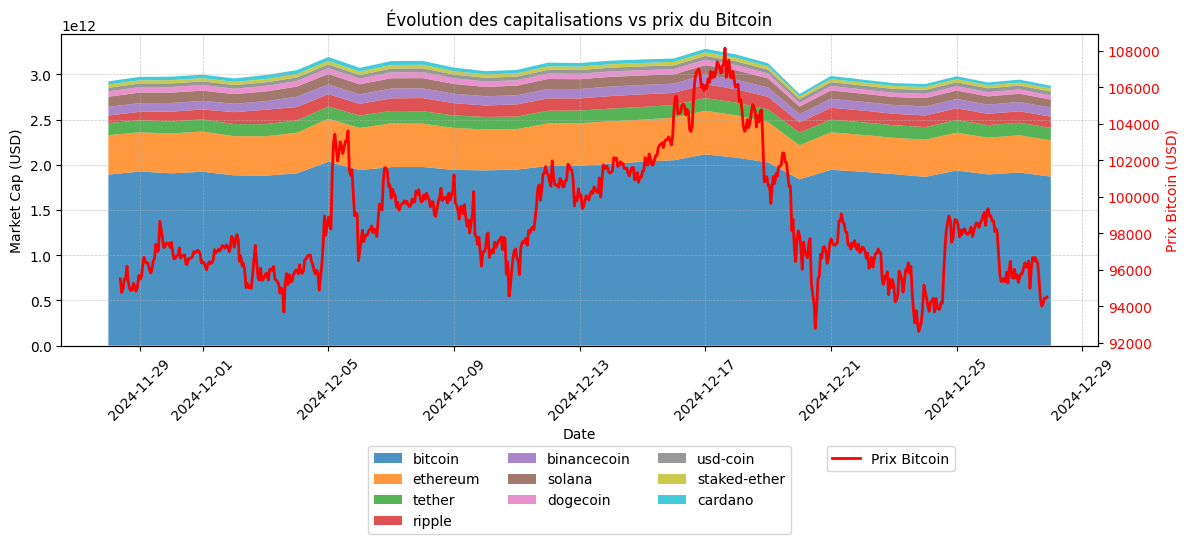

In [30]:
# Récupérer les noms des cryptos (toutes les colonnes sauf Date)
crypto_columns = df_market_cap.columns[1:]  # Exclure la colonne 'Date'

# Création de la figure et du premier axe (market cap)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.stackplot(
    df_market_cap["Date"],  # Axe des X
    *[df_market_cap[col] for col in crypto_columns],  # Toutes les colonnes sauf 'Date' et 'Bitcoin_Price'
    labels=crypto_columns,  # Les noms des colonnes comme légendes
    alpha=0.8,
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Market Cap (USD)")
ax1.set_title("Évolution des capitalisations vs prix du Bitcoin")
ax1.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.30),
    ncol=len(crypto_columns)/3,
)

# Grille pour le premier axe
ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax1.tick_params(axis="x", rotation=45)

# Création du second axe pour le cours du Bitcoin
ax2 = ax1.twinx()  # Axe secondaire partageant l'axe X
ax2.plot(
    df_crypto["Date"],
    df_crypto["Price"],
    color="red",
    label="Prix Bitcoin",
    linewidth=2,
)
ax2.set_ylabel("Prix Bitcoin (USD)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Légende pour l'axe secondaire
ax2.legend(
    loc="upper center",
    bbox_to_anchor=(0.8, -0.30),
    ncol=len(crypto_columns),
)

# Ajuster l'affichage
plt.tight_layout()
plt.show()